# A Yosys Plugin for Finding Paths in Circuit Designs

## Introduction
In this presentation, we will explore a Yosys plugin that combines graph theory and circuit analysis techniques to find paths between two specified signals in a digital circuit design. Yosys is an open-source framework for digital circuit synthesis and optimization, providing a powerful toolset for working with digital circuits.

## Understanding Yosys
Yosys is a framework for Verilog RTL synthesis and more. It provides a collection of tools for parsing, analyzing, optimizing, and manipulating digital circuit designs. Some key concepts in Yosys include:

- **Module**: A hierarchical building block in a circuit design that encapsulates functionality.
- **Signal**: A wire or a connection in a digital circuit that carries a value.
- **Cell**: A basic building block in a digital circuit, such as logic gates or flip-flops.
- **Selection**: A subset of objects (modules, cells, wires) in a design that can be manipulated or analyzed separately.

Yosys allows users to write plugins to extend its functionality and perform custom analysis and transformations on circuit designs.

## Graph Theory Concepts
Graph theory is a branch of mathematics that studies graphs, which are mathematical structures used to model pairwise relations between objects. In the context of digital circuits, we can represent a circuit as a directed graph, where:

- **Nodes**: Represent signals in the circuit.
- **Edges**: Represent connections between signals.

Some fundamental concepts in graph theory that are relevant to our plugin include:

- **Paths**: A sequence of edges that connect a sequence of nodes.
- **Directed Acyclic Graph (DAG)**: A directed graph with no cycles.
- **Topological Sorting**: A linear ordering of the nodes in a DAG such that for every directed edge from node A to node B, node A comes before node B in the ordering.
- **Depth-First Search (DFS)**: An algorithm for traversing or searching a graph by exploring as far as possible along each branch before backtracking.
- **In-Degree**: The number of incoming edges to a node in a directed graph.
- **Adjacency List**: A data structure used to represent a graph, where each node is associated with a list of its adjacent nodes.

## Plugin Functionality
The Yosys plugin we developed performs the following tasks:

1. Parses the "-from" and "-to" arguments to specify the starting and ending signals for the path search.
2. Operates on the selected modules in the circuit design.
3. Builds a directed graph representation of the circuit, considering signals as nodes and cell connections as edges.
4. Performs a topological sorting of the graph to ensure proper traversal order.
5. Uses a depth-first search (DFS) algorithm to explore the circuit graph and find paths between the specified signals.
6. Maintains a mapping of signals to their connected cells and other signals for efficient traversal.
7. Reports the sequence of signals and cells along the found path, if any.
8. Provides a warning message if no path is found.
9. Optionally generates a schematic representation of the path using Yosys's "show" command.

Here's a detailed flow of the plugin's execution:

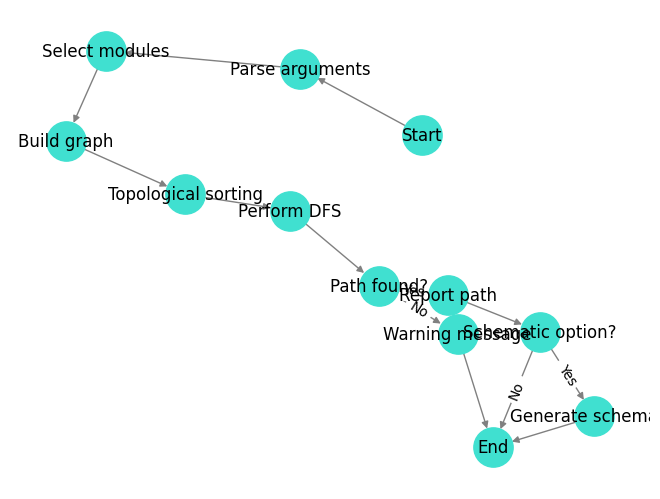

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

G.add_node("Start")
G.add_node("Parse arguments")
G.add_node("Select modules")
G.add_node("Build graph")
G.add_node("Topological sorting")
G.add_node("Perform DFS")
G.add_node("Path found?")
G.add_node("Report path")
G.add_node("Warning message")
G.add_node("Schematic option?")
G.add_node("Generate schematic")
G.add_node("End")

G.add_edge("Start", "Parse arguments")
G.add_edge("Parse arguments", "Select modules")
G.add_edge("Select modules", "Build graph")
G.add_edge("Build graph", "Topological sorting")
G.add_edge("Topological sorting", "Perform DFS")
G.add_edge("Perform DFS", "Path found?")
G.add_edge("Path found?", "Report path", label="Yes")
G.add_edge("Path found?", "Warning message", label="No")
G.add_edge("Report path", "Schematic option?")
G.add_edge("Schematic option?", "Generate schematic", label="Yes")
G.add_edge("Schematic option?", "End", label="No")
G.add_edge("Warning message", "End")
G.add_edge("Generate schematic", "End")

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=800, node_color='turquoise', font_size=12, 
        edge_color='gray', arrows=True)
labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.axis('off')
plt.show()

## Code Walkthrough
Some key code snippets from the plugin:

```cpp
struct LtpWorker {
    // ...
    void run() {
        log_debug("Running DFS from %s\n", log_signal(from_bit));
        path_found = dfs(from_bit);

        if (!path.empty()) {
            // ...
            for (size_t i = 0; i < path_size; ++i) {
                Cell *via = nullptr;
                if (!path_with_cells.empty() && i < path_with_cells.size()) {
                    via = path_with_cells[i].second;
                }
                log("%5zu: %s (via %s)\n", i, log_signal(path[i]),
                    via ? log_id(via) : "null");
            }
            log("\n");
        } else {
            // ...
        }
    }
};
```

In the `run()` method, the plugin performs the following steps:
1. Initiates the DFS traversal from the "from" signal using the `dfs()` function.
2. If a path is found, it reports the sequence of signals and cells along the path.
3. If no path is found, it provides a warning message.

```cpp
bool dfs(SigBit current_bit) {
    // ...
    if (current_bit == from_bit) {
        path.push_back(current_bit);
    }

    if (to_bit && sigmap(current_bit) == sigmap(*to_bit)) {
        // ...
        return true;
    }

    if (busy.count(current_bit) > 0) {
        // ...
        return false;
    }
    busy.insert(current_bit);

    bool path_exists = false;
    if (bit2bits.count(current_bit)) {
        for (auto &it : bit2bits.at(current_bit)) {
            if (dfs(it.first)) {
                path_with_cells.push_back({current_bit, it.second});
                path_exists = true;
                if (to_bit) {
                    break;
                }
            }
        }
    }

    if (!to_bit || path_exists) {
        path.push_back(current_bit);
    }

    busy.erase(current_bit);
    return path_exists;
}
```

The `dfs()` function implements the depth-first search algorithm to traverse the circuit graph:
1. If the current signal matches the "from" signal, it adds it to the path.
2. If the current signal matches the "to" signal, it returns true to indicate a path is found.
3. If the current signal is already visited (in the `busy` set), it returns false to avoid cycles.
4. It recursively explores the adjacent signals using the `bit2bits` mapping, which represents the adjacency list of the graph.
5. If a path is found, it adds the current signal and the corresponding cell to the `path_with_cells` vector.
6. Finally, it adds the current signal to the path if a path exists or if the "to" signal is not specified.

The plugin also supports generating a schematic representation of the path using Yosys's "show" command. This is triggered when the "-schematic" option is provided. The relevant code snippet is as follows:

```cpp
if (schematic && worker.path_found) {
    RTLIL::Selection path_selection(false);

    for (const auto &element : worker.path_with_cells) {
        Cell *cell = element.second;
        SigBit bit = element.first;
        if (cell) {
            path_selection.select(module, cell);
        }
        if (bit.wire) {
            path_selection.select(module, bit.wire);
        }
    }

    Pass::call_on_selection(module->design, path_selection, "show");
}
```

When the schematic option is enabled, and a path is found, the plugin creates a new selection in Yosys containing the cells and wires along the path. It then calls the "show" command on this selection to generate a schematic representation of the path.

### Example

#### Compiling the Plugin
This will create the plugin called `path` (the `path pass` will be available in the system as soon as we load the compiled external object).

In [39]:
import os

!yosys-config --build path.so main.cc

if os.path.exists("./path.so"):
    print("File created successfully!")
else:
    print("File creation failed.")

File created successfully!


#### Circuit Example

In [40]:
!cat top.sv

`default_nettype none
module top (input wire clk, rstn, din, output logic q);
  logic [3:0] tmp;
	  always_ff @(posedge clk) begin
		  if(!rstn) tmp <= '0;
		  else begin
			  for(int i = 0; i < 4; i++) begin
				  if(i == 0) tmp[i] <= din;
				  else tmp[i] <= tmp[i-1];
	                  end
	         end
	end
  assign q = tmp[3];
endmodule
`default_nettype wire


The goal is simple, check if there's a path between `din` and `q`.

In [41]:
!yosys -QT -m path.so -p "read_verilog -sv top.sv; synth; debug path -from din -to q -schematic; write_ilang top.il" && cp ~/.yosys_show.dot ./out.dot


-- Running command `read_verilog -sv top.sv; synth; debug path -from din -to q -schematic; write_ilang top.il' --

1. Executing Verilog-2005 frontend: top.sv
Parsing SystemVerilog input from `top.sv' to AST representation.
Generating RTLIL representation for module `\top'.
Successfully finished Verilog frontend.

2. Executing SYNTH pass.

2.1. Executing HIERARCHY pass (managing design hierarchy).

2.2. Executing PROC pass (convert processes to netlists).

2.2.1. Executing PROC_CLEAN pass (remove empty switches from decision trees).
Found and cleaned up 4 empty switches in `\top.$proc$top.sv:4$3'.
Cleaned up 4 empty switches.

2.2.2. Executing PROC_RMDEAD pass (remove dead branches from decision trees).
Marked 1 switch rules as full_case in process $proc$top.sv:4$3 in module top.
Removed a total of 0 dead cases.

2.2.3. Executing PROC_PRUNE pass (remove redundant assignments in processes).
Removed 1 redundant assignment.
Promoted 1 assignment to connection.

2.2.4. Executing PROC_INIT 

In [42]:
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable


In [43]:
from graphviz import Source
from IPython.display import display, HTML

src = Source.from_file('out.dot')
svg_output = src.pipe(format='svg').decode('utf-8')
html_output = f"<div style='width:800px; height:600px; overflow:auto;'>{svg_output}</div>"
display(HTML(html_output))

#### Another Example

In [46]:
!yosys -QT -m path.so -p "read_ilang top.il; debug path -from tmp[1] -to tmp[2] -schematic" && cp ~/.yosys_show.dot ./out_small.dot


-- Running command `read_ilang top.il; debug path -from tmp[1] -to tmp[2] -schematic' --

1. Executing RTLIL frontend.
Input filename: top.il

2. Executing path pass (find path from 'from' to 'to').
Processing module: top
Resolved from_bit: \tmp [1], to_bit: \tmp [2]
Running DFS from \tmp [1]
DFS at bit: \tmp [1]
DFS at bit: \tmp [2]
Reached to_bit: \tmp [2]
    0: \tmp [1] (via $auto$ff.cc:266:slice$104)
    1: \tmp [2] (via null)

3. Generating Graphviz representation of design.
Writing dot description to `/home/dhdezr/.yosys_show.dot'.
Dumping selected parts of module top to page 1.
Exec: { test -f '/home/dhdezr/.yosys_show.dot.pid' && fuser -s '/home/dhdezr/.yosys_show.dot.pid' 2> /dev/null; } || ( echo $$ >&3; exec xdot '/home/dhdezr/.yosys_show.dot'; ) 3> '/home/dhdezr/.yosys_show.dot.pid' &


In [47]:
src = Source.from_file('out_small.dot')
svg_output = src.pipe(format='svg').decode('utf-8')
html_output = f"<div style='width:800px; height:600px; overflow:auto;'>{svg_output}</div>"
display(HTML(html_output))